# Datathon Crushers
## The Task
The data has metrics:

* Visitors per week starting from the first Monday of June
* Minimum temperature per day
* Maximum temperature per day
* Average rainfall (snowfall) per day
* Prices of nearby accomodation

In [68]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
xls = pd.ExcelFile("2025 Allianz Datathon Dataset.xlsx")
xls.sheet_names

['readme', 'Visitation Data', 'Climate Data']

In [4]:
visitDataRaw = xls.parse('Visitation Data')
visitDataRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Year            165 non-null    int64
 1   Week            165 non-null    int64
 2   Mt. Baw Baw     165 non-null    int64
 3   Mt. Stirling    165 non-null    int64
 4   Mt. Hotham      165 non-null    int64
 5   Falls Creek     165 non-null    int64
 6   Mt. Buller      165 non-null    int64
 7   Selwyn          165 non-null    int64
 8   Thredbo         165 non-null    int64
 9   Perisher        165 non-null    int64
 10  Charlotte Pass  165 non-null    int64
dtypes: int64(11)
memory usage: 14.3 KB


### Inference
* n = 165 observations
* No missing values
* All attributes are numerical


In [6]:
visitDataRaw.describe()

,Year,Week,Mt. Baw Baw,Mt. Stirling,Mt. Hotham,Falls Creek,Mt. Buller,Selwyn,Thredbo,Perisher,Charlotte Pass
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,2019.000000,8.000000,5373.648485,589.981818,20110.333333,24027.145455,29349.296970,5536.533333,30020.884848,39649.515152,2181.812121
std,3.171904,4.333646,3924.269031,529.497558,12198.935589,14176.688461,17768.711945,3383.338655,18363.819945,24258.783674,1334.790842
min,2014.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,4.000000,1757.000000,98.000000,8368.000000,8741.000000,12397.000000,2180.000000,11543.000000,15236.000000,842.000000
50%,2019.000000,8.000000,5565.000000,480.000000,21856.000000,28099.000000,33328.000000,6454.000000,34676.000000,46265.000000,2542.000000
75%,2022.000000,12.000000,8513.000000,962.000000,30944.000000,36692.000000,44315.000000,8530.000000,46015.000000,60788.000000,3344.000000
max,2024.000000,15.000000,18031.000000,2097.000000,44648.000000,49697.000000,66326.000000,12863.000000,70634.000000,93226.000000,5033.000000


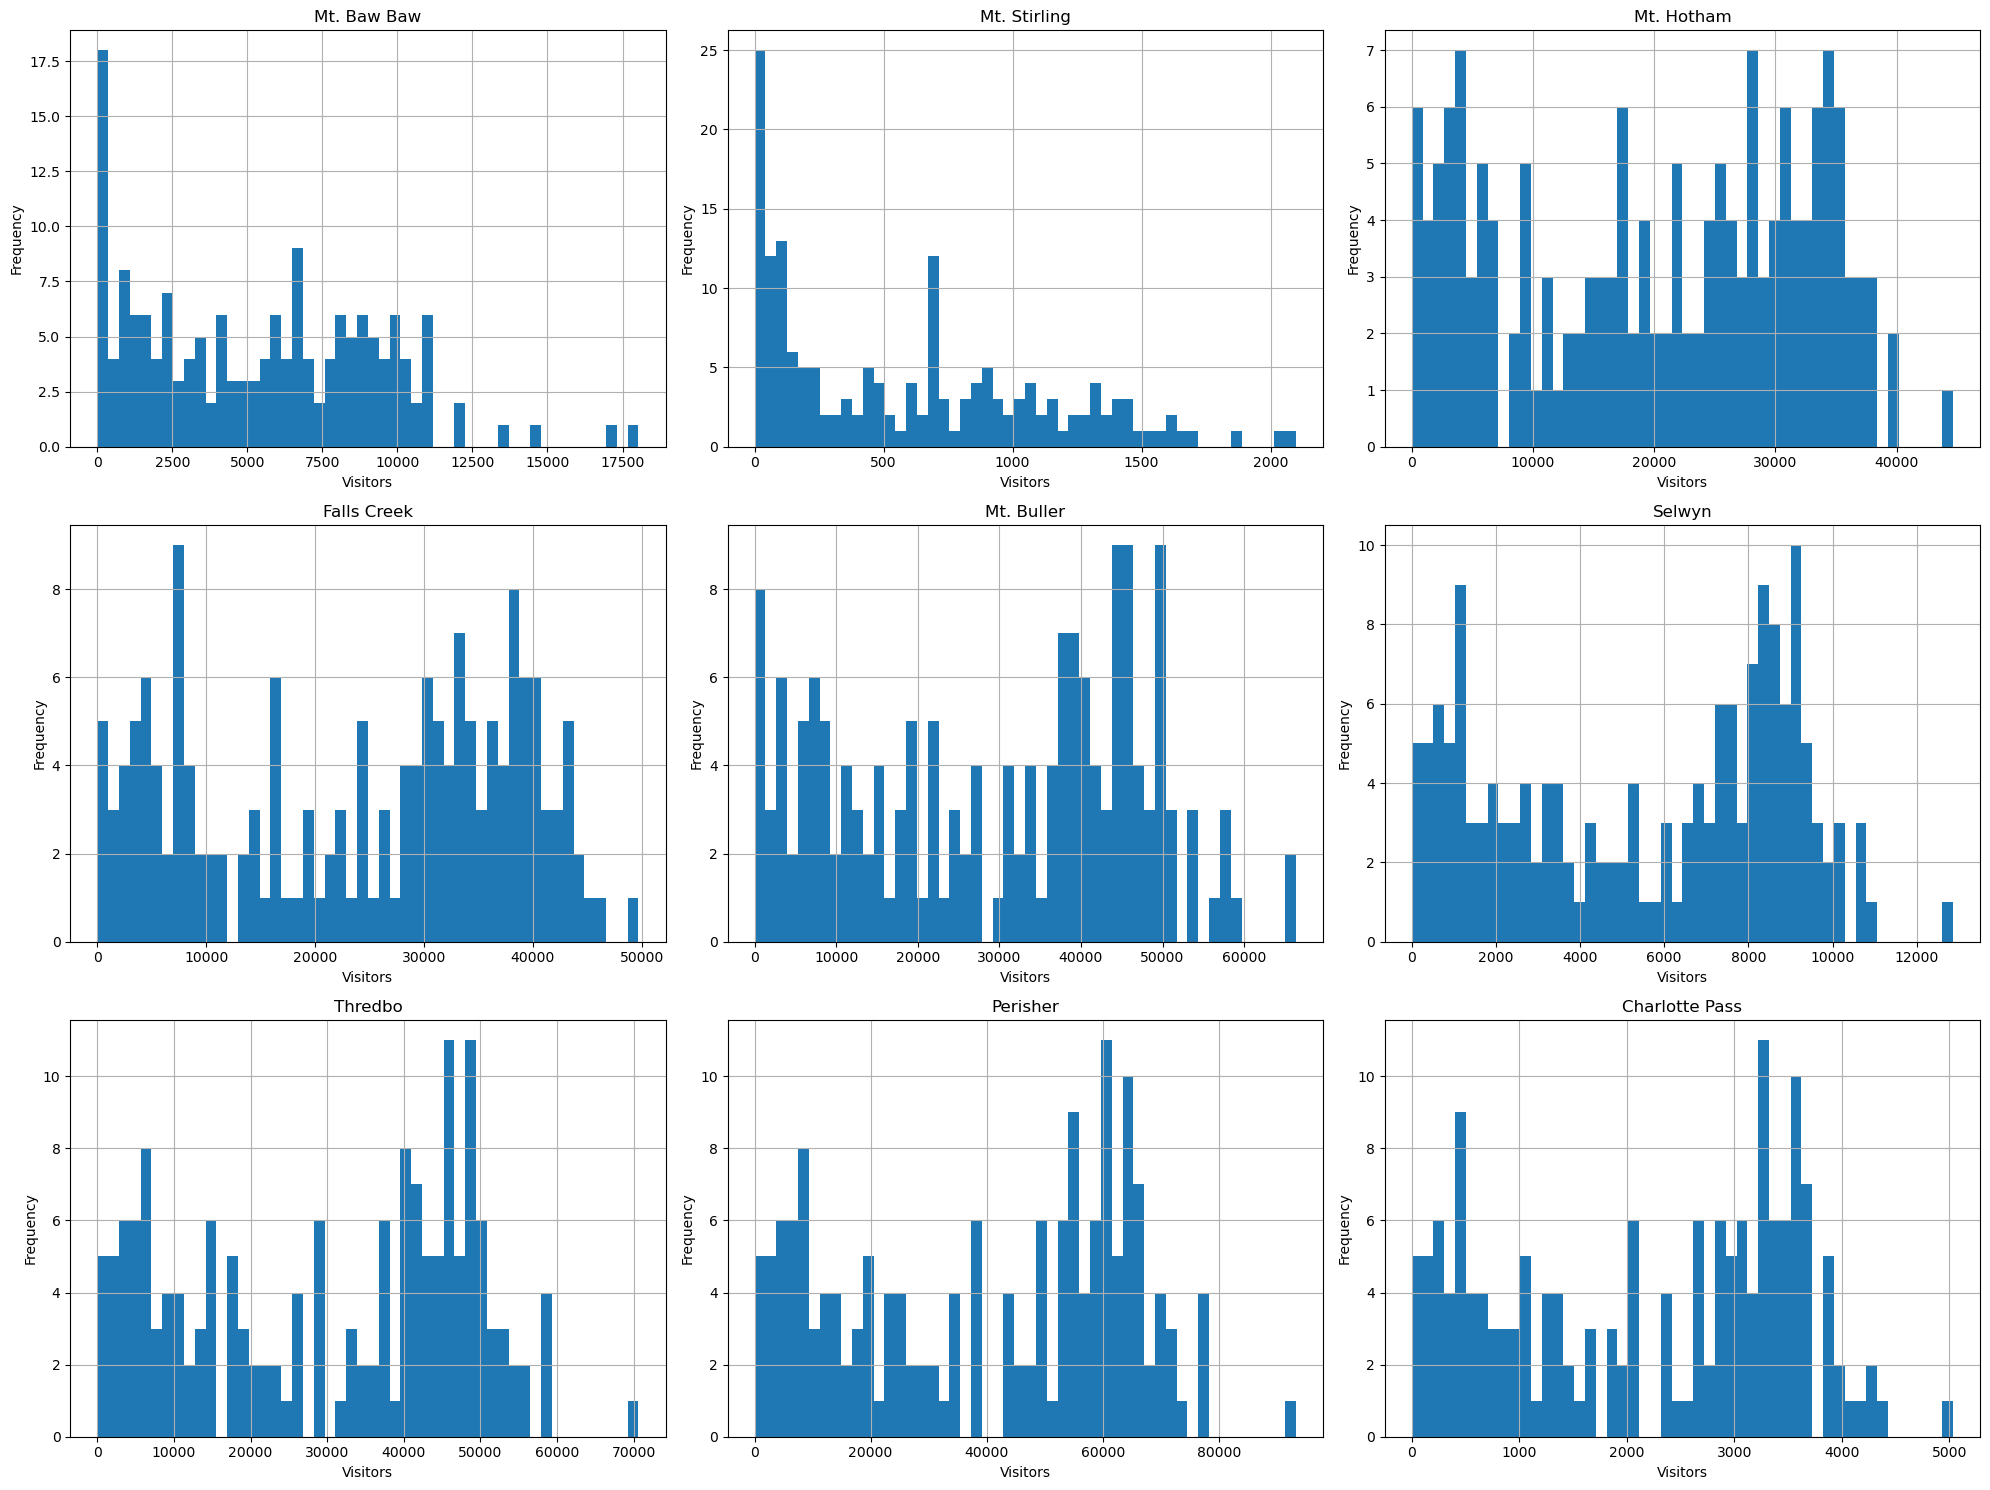

In [7]:
fig = visitDataRaw.iloc[:, 2:].hist(bins=50, figsize=(20, 15))

for ax_row in fig:
    for ax in ax_row:
        ax.set_xlabel("Visitors")
        ax.set_ylabel("Frequency")
        
plt.tight_layout()
plt.show()

### Inference
* All units are identical
* 0 indicators days in which the resort was closed
* Mt. Baw Baw and Mt. Stirling are right skewed
* Most of the resorts exhibit double peaks
    * There are 'peak' periods and 'non-peak' periods

## Cleaning Data

In [10]:
class cleanVisit:
    def __init__(self, data):
        self.data = data
        
    def fromWeeksToDates(self):
        years = self.data['Year'].astype(int)
        weeks = self.data['Week'].astype(int)
        june1 = pd.to_datetime(dict(year=years, month=6, day=1))
        first_mon = june1 + pd.to_timedelta((7 - june1.dt.weekday) % 7, unit='D')
        self.data['Dates'] = first_mon + pd.to_timedelta(weeks - 1, unit='W')
        self.data = self.data.drop(columns=['Year', 'Week'])
        self.data = self.data[['Dates'] + [c for c in self.data.columns if c != 'Dates']]
        self.data = self.data.sort_values(by='Dates')

    def getResort(self, i):
        self.data = self.data.iloc[:, [0, i]]

class climateClean:
    def __init__(self, data):
        self.data = data

    def fromYMDtoDates(self):
        self.data['Dates'] = self.data.apply(lambda row: datetime(int(row['Year']), int(row['Month']), int(row['Day'])), axis=1)
        self.data.drop(columns=['Year', 'Month', 'Day'], inplace=True)
        self.data = self.data[['Dates'] + [col for col in self.data.columns if col != 'Dates']]

    def filterStation(self, station):
        self.data = self.data[self.data['Bureau of Meteorology station number'] == station]

    def getAve(self):
        self.data['WeekStart'] = self.data['Dates'] - pd.to_timedelta(self.data['Dates'].dt.weekday, unit='d')
        
        weekly = self.data.groupby('WeekStart').agg({
            'Maximum temperature (Degree C)': 'mean',
            'Minimum temperature (Degree C)': 'mean',
            'Rainfall amount (millimetres)': 'sum'
        }).rename(columns={
            'Maximum temperature (Degree C)': 'MaxTemp',
            'Minimum temperature (Degree C)': 'MinTemp',
            'Rainfall amount (millimetres)': 'Rain'
        }).reset_index()
        
        self.data = self.data.merge(weekly, on='WeekStart', how='left')
        
        self.data['Maximum temperature (Degree C)'] = self.data['MaxTemp']
        self.data['Minimum temperature (Degree C)'] = self.data['MinTemp']
        self.data['Rainfall amount (millimetres)'] = self.data['Rain']

        self.data.drop(columns=['WeekStart', 'MaxTemp', 'MinTemp', 'Rain'], inplace=True)


    def keepRelevantData(self, data):
        self.data = self.data[self.data['Dates'].isin(data['Dates'])]

    def combineData(self, data):
        self.data = pd.DataFrame(np.hstack([data, self.data.drop(['Dates'], axis = 1)]))

## Creating training and test set
* We stratify based on year to ensure that the training sets has same amount of each year

In [12]:
train_setRAW, test_setRAW = train_test_split(visitDataRaw, test_size=0.2, random_state=42, stratify = visitDataRaw['Year'])
train_set = cleanVisit(train_setRAW)
train_set.fromWeeksToDates()
test_set = cleanVisit(test_setRAW)
test_set.fromWeeksToDates()

In [13]:
train = train_set.data
train

,Dates,Mt. Baw Baw,Mt. Stirling,Mt. Hotham,Falls Creek,Mt. Buller,Selwyn,Thredbo,Perisher,Charlotte Pass
0,2014-06-02,555,60,3483,2790,8296,1041,5535,7370,408
1,2014-06-09,804,42,1253,1425,1987,383,2090,2751,151
2,2014-06-16,993,30,2992,2101,2413,597,3216,4255,230
4,2014-06-30,11112,645,29628,26211,49217,8588,46546,61339,3403
5,2014-07-07,13381,1316,36665,33392,59693,10682,58668,76855,4305
...,...,...,...,...,...,...,...,...,...,...
160,2024-08-12,5977,1416,24260,38541,43387,6859,37608,49136,2667
161,2024-08-19,3597,701,19289,42101,36668,5969,33208,43382,2392
162,2024-08-26,1500,213,14487,25252,15415,3351,18120,23908,1323
163,2024-09-02,0,0,2700,17137,0,1177,6270,8244,454


## Plots

In [15]:
visitDataObj = cleanVisit(visitDataRaw)
visitDataObj.fromWeeksToDates()
visitDataObj.data

,Dates,Mt. Baw Baw,Mt. Stirling,Mt. Hotham,Falls Creek,Mt. Buller,Selwyn,Thredbo,Perisher,Charlotte Pass
0,2014-06-02,555,60,3483,2790,8296,1041,5535,7370,408
1,2014-06-09,804,42,1253,1425,1987,383,2090,2751,151
2,2014-06-16,993,30,2992,2101,2413,597,3216,4255,230
3,2014-06-23,2976,165,9680,9544,18831,2877,15497,20265,1134
4,2014-06-30,11112,645,29628,26211,49217,8588,46546,61339,3403
...,...,...,...,...,...,...,...,...,...,...
160,2024-08-12,5977,1416,24260,38541,43387,6859,37608,49136,2667
161,2024-08-19,3597,701,19289,42101,36668,5969,33208,43382,2392
162,2024-08-26,1500,213,14487,25252,15415,3351,18120,23908,1323
163,2024-09-02,0,0,2700,17137,0,1177,6270,8244,454


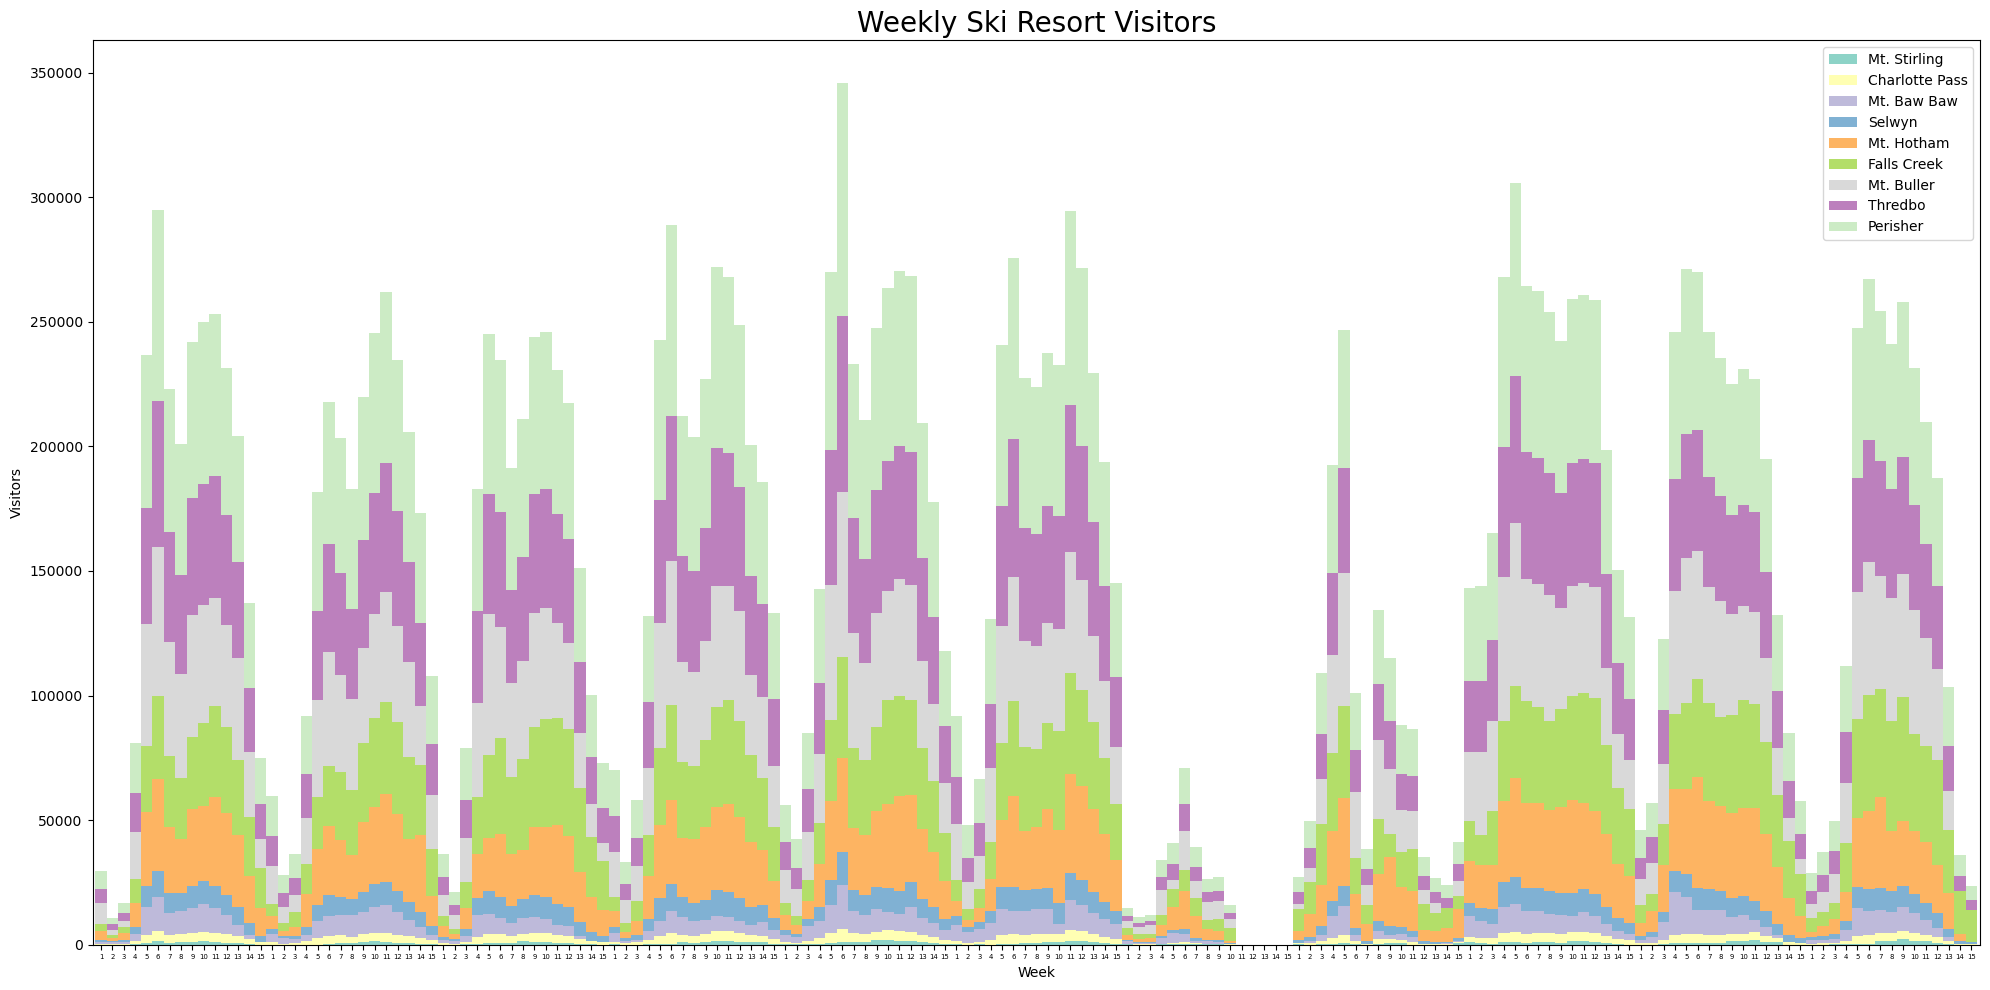

In [16]:
# Prepare data
df_area = visitDataObj.data.copy()
df_area = df_area.drop(columns=['Year', 'Week'], errors='ignore')
df_area.set_index('Dates', inplace=True)

# Sort columns by total visitors (smallest to largest)
sorted_cols = df_area.sum().sort_values().index
df_area = df_area[sorted_cols]

# Optional: downsample to fewer dates if too dense
# df_area = df_area.resample('2W').sum()  # or '1M' or slice every nth row

# Use modern colormap API
colormap = matplotlib.colormaps.get_cmap('Set3')
colors = [colormap(i / df_area.shape[1]) for i in range(df_area.shape[1])]

# Plot stacked bar
df_area.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors, width=1)

plt.title("Weekly Ski Resort Visitors", fontsize=20)
plt.ylabel("Visitors")
plt.xlabel("Week")

num_weeks = df_area.shape[0]
xtick_labels = [(i % 15) + 1 for i in range(num_weeks)]
plt.xticks(ticks=range(num_weeks), labels=xtick_labels, rotation=0, fontsize=5)

plt.tight_layout()
plt.show()

### Inference (To do)
* Week 2 has the lowest amount of people
* We observe the double peaks during season with middle of the peaks having less people
* The trough of the peaks is moving right as time progresses
* 2020 data and 2021 are invalid beacuse of COVID policy and pandemic restrictions

## Slicing Data

SARIMA essentially splits the data into week 1, week 2 etc. and individually performs an ARIMA analysis on them. Therefore, we need to keep the other weeks data points.

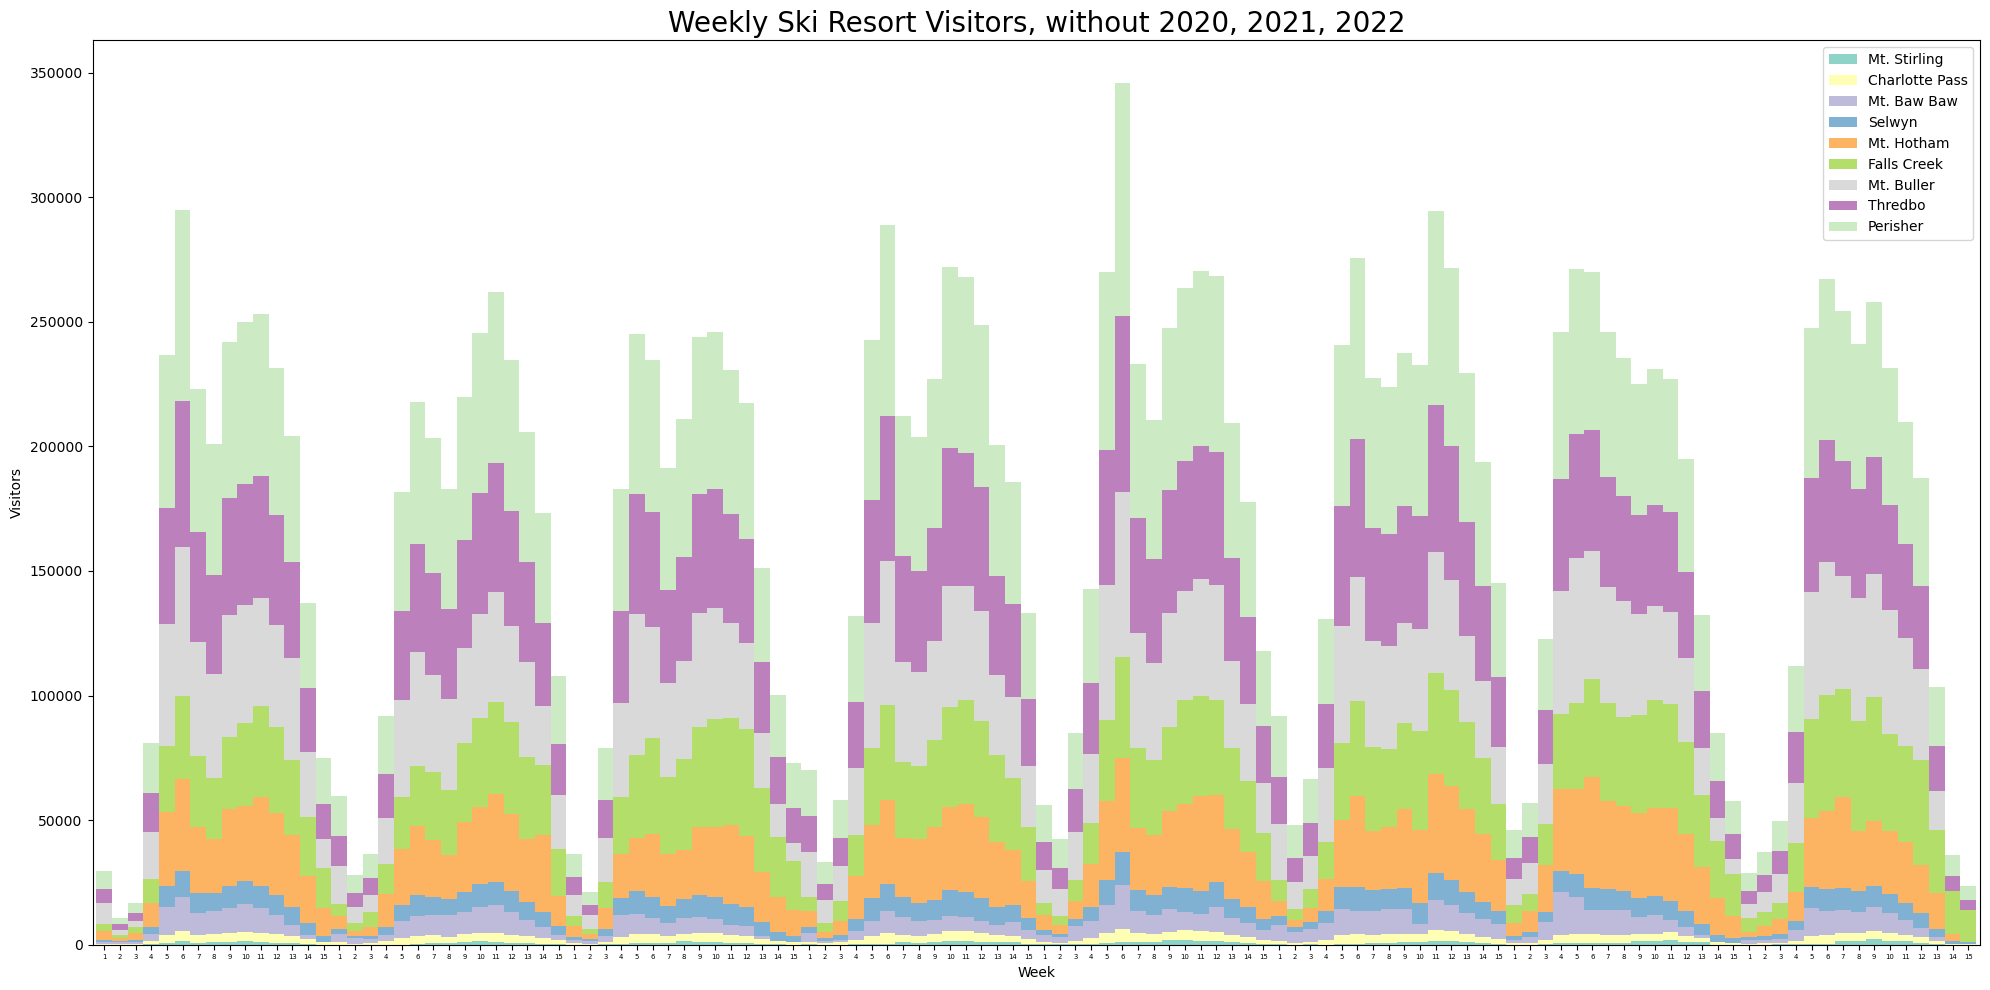

In [86]:
visitData_sliced = visitDataObj.data[~visitDataObj.data['Dates'].dt.year.isin([2020, 2021, 2022])]

# Prepare data
df_area = visitData_sliced.copy()
df_area = df_area.drop(columns=['Year', 'Week'], errors='ignore')
df_area.set_index('Dates', inplace=True)

# Sort columns by total visitors (smallest to largest)
sorted_cols = df_area.sum().sort_values().index
df_area = df_area[sorted_cols]

# Optional: downsample to fewer dates if too dense
# df_area = df_area.resample('2W').sum()  # or '1M' or slice every nth row

# Use modern colormap API
colormap = matplotlib.colormaps.get_cmap('Set3')
colors = [colormap(i / df_area.shape[1]) for i in range(df_area.shape[1])]

# Plot stacked bar
df_area.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors, width=1)

plt.title("Weekly Ski Resort Visitors, without 2020, 2021, 2022", fontsize=20)
plt.ylabel("Visitors")
plt.xlabel("Week")

num_weeks = df_area.shape[0]
xtick_labels = [(i % 15) + 1 for i in range(num_weeks)]
plt.xticks(ticks=range(num_weeks), labels=xtick_labels, rotation=0, fontsize=5)

plt.tight_layout()
plt.show()

### Inferences
We removed 2020, 2021, 2022.
Reasons:
* Messed up data
* 2022 week 1, 2, 3 were not good (too high from people wanting to come back)

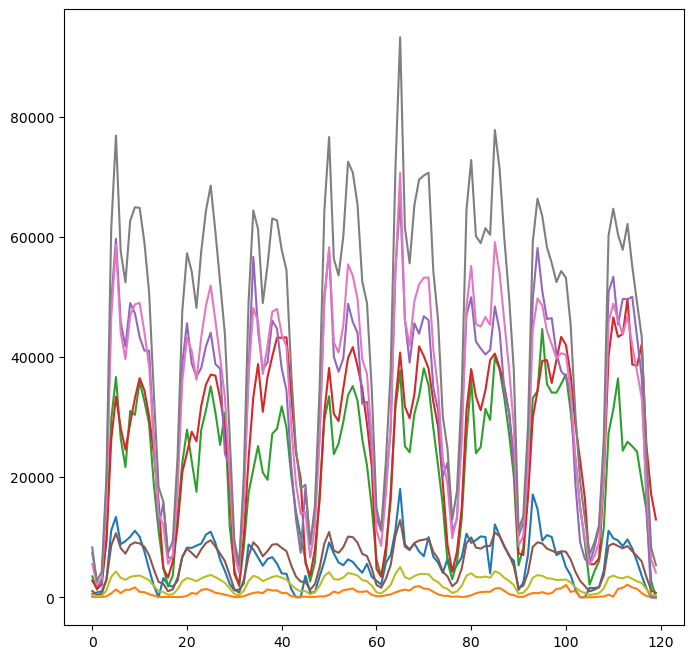

In [107]:
cleaned_visit = visitData_sliced.reset_index(drop=True).drop(['Dates'], axis = 1)
fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(cleaned_visit)

### Inferences
* Periodic pattern
* Auto regression